# CC3084 – Data Science — **Laboratorio 5: RNN (LSTM) para Series de Tiempo**

**Serie:** *Industrial Production: Ice cream and frozen dessert (IPN31152N)*  
**Fuente:** FRED (Federal Reserve Bank of St. Louis) — https://fred.stlouisfed.org/series/IPN31152N


## 0) Preparación del entorno


In [3]:
%pip install -q pandas numpy matplotlib pandas_datareader

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\50250\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator as TimeSeriesGenerator

# Reproducibilidad
np.random.seed(3084)
tf.random.set_seed(3084)

print(tf.__version__)

2.13.0


## 1) Carga y exploración de datos

La serie **IPN31152N** está en FRED. Intentaremos descargarla con `pandas_datareader`.  

- **Units**: Index 2012=100, Not Seasonally Adjusted  
- **Frequency**: Monthly


In [5]:
def load_series(local_csv='IPN31152N.csv'):
    try:
        df = pdr.DataReader('IPN31152N', 'fred')
        df = df.rename(columns={'IPN31152N':'value'})
        df.index = pd.to_datetime(df.index)
        print('Descarga desde FRED exitosa.')
    except Exception as e:
        print('No se pudo descargar desde FRED. Intentando CSV local...', e)
        df = pd.read_csv(local_csv, parse_dates=['DATE'])
        df = df.rename(columns={'IPN31152N':'value', 'DATE':'date'})
        df = df.set_index('date')
    # Limpieza básica
    df = df.dropna()
    # Nos quedamos con frecuencia mensual y ordenamos por tiempo
    df = df.asfreq('MS')  # Month Start
    df = df.sort_index()
    return df

series = load_series()
series.head(), series.tail(), series.describe()

Descarga desde FRED exitosa.


(               value
 DATE                
 2020-10-01  106.2640
 2020-11-01   99.5616
 2020-12-01   90.4432
 2021-01-01  106.0187
 2021-02-01  119.2644,
                value
 DATE                
 2025-02-01  108.9906
 2025-03-01  114.5922
 2025-04-01  116.9527
 2025-05-01  118.2192
 2025-06-01  127.0128,
             value
 count   57.000000
 mean   114.091800
 std     13.670936
 min     85.283900
 25%    105.391900
 50%    118.219200
 75%    124.978700
 max    132.817000)

### Exploración inicial y visualización

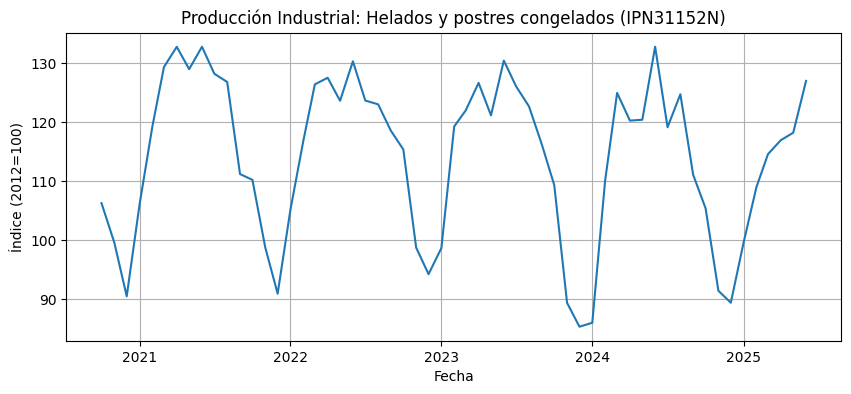

Rango temporal: 2020-10-01 → 2025-06-01
Número de observaciones: 57


In [6]:
plt.figure(figsize=(10,4))
plt.plot(series.index, series['value'])
plt.title('Producción Industrial: Helados y postres congelados (IPN31152N)')
plt.xlabel('Fecha')
plt.ylabel('Índice (2012=100)')
plt.grid(True)
plt.show()

print('Rango temporal:', series.index.min().date(), '→', series.index.max().date())
print('Número de observaciones:', len(series))

## 2) División de conjuntos

Usaremos los **últimos 24 meses** como conjunto de prueba. El resto será entrenamiento.


In [7]:
test_horizon = 24
train = series.iloc[:-test_horizon].copy()
test  = series.iloc[-test_horizon:].copy()

print('Tamaño train:', len(train), '| Tamaño test:', len(test))
train.tail(), test.head()

Tamaño train: 33 | Tamaño test: 24


(               value
 DATE                
 2023-02-01  119.2751
 2023-03-01  122.0175
 2023-04-01  126.6790
 2023-05-01  121.1606
 2023-06-01  130.4626,
                value
 DATE                
 2023-07-01  126.0569
 2023-08-01  122.6748
 2023-09-01  116.2177
 2023-10-01  109.3279
 2023-11-01   89.3353)